<h1>LSTM remove outlier with zscore</h1>

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell

# LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.svm import OneClassSVM
from tensorflow.keras.layers import Dropout, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler
from scipy.stats import skew


InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [27]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [28]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [29]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [30]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [31]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [32]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [33]:
# Global selection
sel_country = old_df[2]

# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1320,ECS010230100302,010000357415,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-11,40,HC,1200.0
1321,ECS010230100303,010000380481,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-16,40,HC,1200.0
1323,ECS010230100304,010000392586,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1322,ECS010230100304,010000390964,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1324,ECS010230100304,010000399293,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1325 non-null   object        
 1   CNTR_ID     1325 non-null   object        
 2   POD_ID      1325 non-null   object        
 3   ETD_POL_D   1325 non-null   object        
 4   PARTY_ID    1325 non-null   object        
 5   PARTY_NAME  1325 non-null   object        
 6   POD         1325 non-null   datetime64[ns]
 7   CNTR_SIZE   1325 non-null   object        
 8   CNTR_TYPE   1325 non-null   object        
 9   RATE        1325 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 113.9+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1336,ECS010230300518,010000531211,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1337,ECS010230300518,010000509487,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1338,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
1339,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
1340,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1340
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1341 non-null   object        
 1   CNTR_ID     1341 non-null   object        
 2   POD_ID      1341 non-null   object        
 3   ETD_POL_D   1341 non-null   object        
 4   PARTY_ID    1341 non-null   object        
 5   PARTY_NAME  1341 non-null   object        
 6   POD         1341 non-null   datetime64[ns]
 7   CNTR_SIZE   1341 non-null   object        
 8   CNTR_TYPE   1341 non-null   object        
 9   RATE        1341 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 115.2+ KB


In [34]:
# Select features
sel_feat = ['POD','RATE']
sel_feat_df = sel_df[sel_feat].copy()  # make a copy to avoid SettingWithCopyWarning

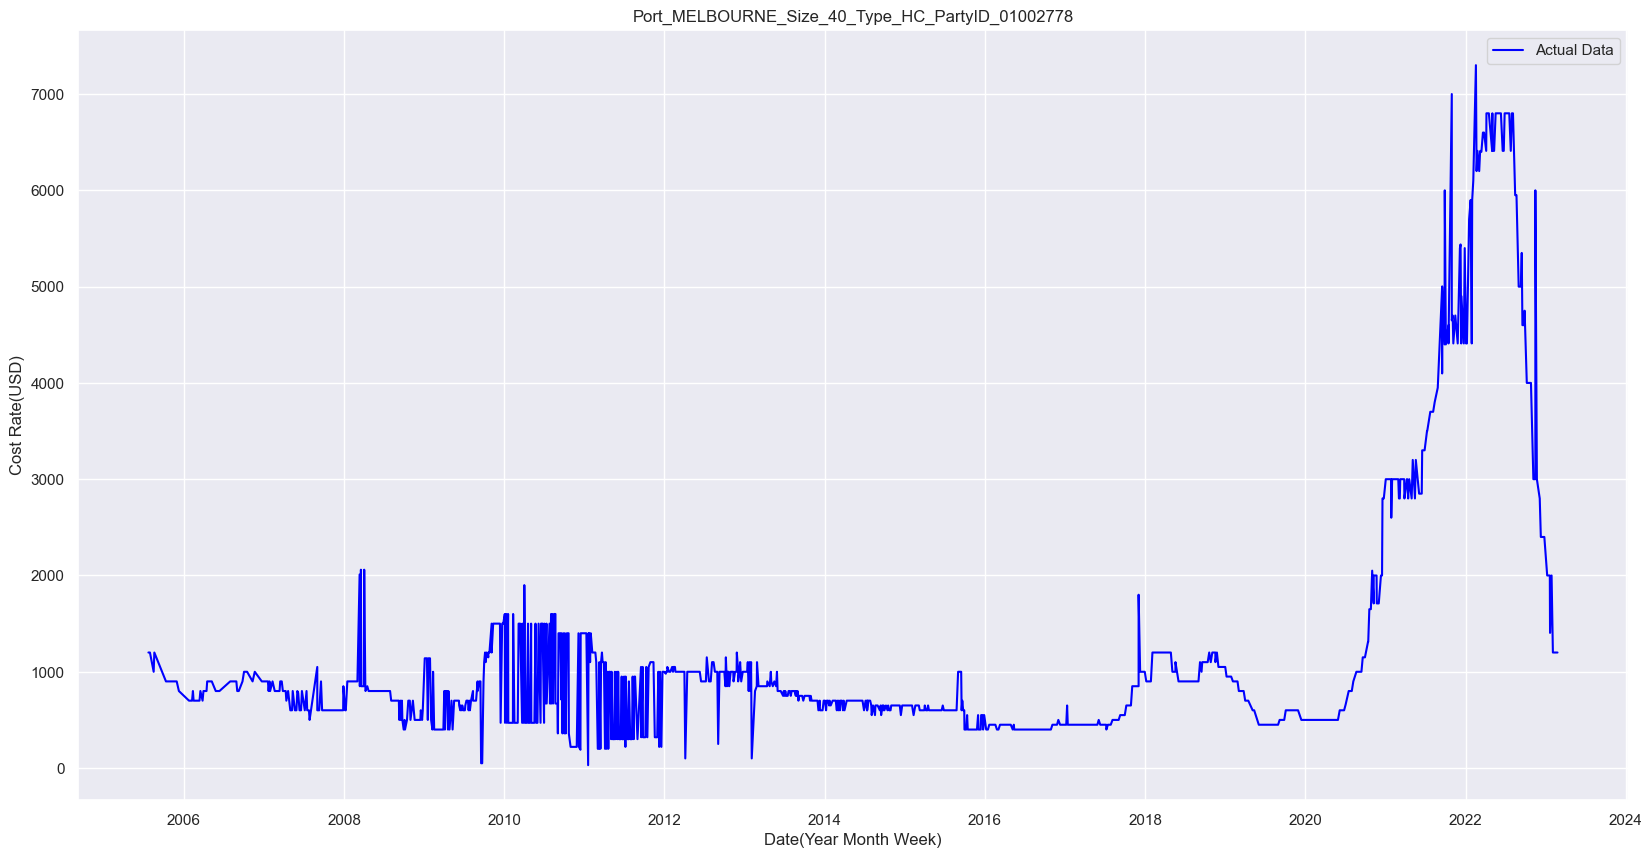

In [35]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'], color='blue', label="Actual Data")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>Detect and Remove Outliers</h4>

In [36]:
# Assuming 'robust_df' is your DataFrame and 'RATE' is the column containing the data
z_scores = stats.zscore(sel_feat_df[['RATE']])
threshold = 3  # Z-score threshold for outlier detection

# Find indices of outliers
outlier_indices = np.where(np.abs(z_scores) > threshold)[0]

# Remove outliers
robust_df = sel_feat_df.drop(sel_feat_df.index[outlier_indices])

# Reset the index
robust_df.reset_index(drop=True, inplace=True)

# Print the modified DataFrame
robust_df.head()
robust_df.info()


,POD,RATE
0,2005-07-23,1200.0
1,2005-07-30,1200.0
2,2005-08-16,1000.0
3,2005-08-19,1200.0
4,2005-10-11,900.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1275 non-null   datetime64[ns]
 1   RATE    1275 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.0 KB


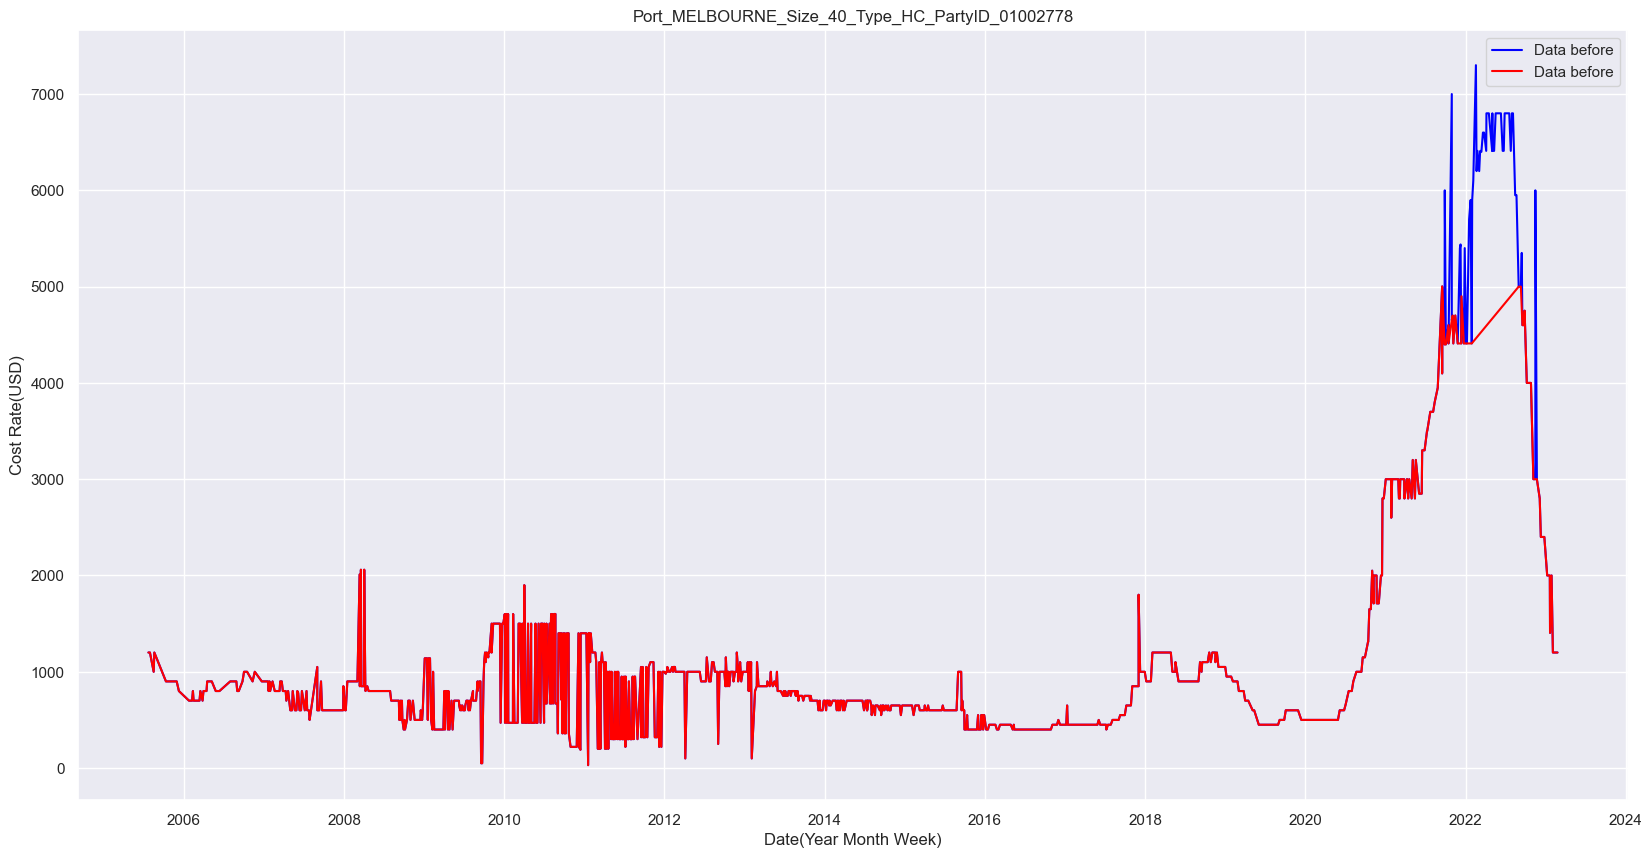

In [37]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'], color='blue', label="Data before")
plt.plot(robust_df['POD'], robust_df['RATE'], color='red', label="Data before")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>Interpolate missing values in between dates</h4>

In [38]:
# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')  

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-07-23,1200.0
1,2005-07-24,1200.0
2,2005-07-25,1200.0
3,2005-07-26,1200.0
4,2005-07-27,1200.0


,POD,RATE
6438,2023-02-20,1200.0
6439,2023-02-21,1200.0
6440,2023-02-22,1200.0
6441,2023-02-23,1200.0
6442,2023-02-24,1200.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6443 entries, 0 to 6442
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6443 non-null   datetime64[ns]
 1   RATE    6443 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 151.0 KB


<h4>Grouping it to week</h4>

In [39]:
# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate trimmed mean of RATE values
    rate_metric = stats.trim_mean(group_df['RATE'].dropna().values, 0.1) # trimming 10% from each end

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_36436\545048384.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_36436\545048384.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_36436\545048384.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_36436\545048384.py:39: FutureWarning: The frame.append method is deprecated and will be remov

,YearMonthWeek,Rate
0,2005-07-18,1200.00
1,2005-07-25,1198.32
2,2005-08-01,1141.18
3,2005-08-08,1058.82
4,2005-08-15,1113.54
5,2005-08-22,1166.04
6,2005-08-29,1126.42
7,2005-09-05,1086.79
8,2005-09-12,1047.17
9,2005-09-19,1007.55


,YearMonthWeek,Rate
903,2022-11-07,3000.00
904,2022-11-14,3000.00
905,2022-11-21,2967.03
906,2022-11-28,2861.54
907,2022-12-05,2571.43
908,2022-12-12,2400.00
909,2022-12-19,2400.00
910,2022-12-26,2307.69
911,2023-01-02,2092.31
912,2023-01-09,2000.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  918 non-null    datetime64[ns]
 1   Rate           918 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [40]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200328,010000409869,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-02,40,HC,1000.0
1,ECS010230200329,010000419018,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-10,40,HC,1000.0
2,ECS010230200330,010000427048,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-16,40,HC,1000.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
13,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
14,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
15,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      16 non-null     object        
 1   CNTR_ID     16 non-null     object        
 2   POD_ID      16 non-null     object        
 3   ETD_POL_D   16 non-null     object        
 4   PARTY_ID    16 non-null     object        
 5   PARTY_NAME  16 non-null     object        
 6   POD         16 non-null     datetime64[ns]
 7   CNTR_SIZE   16 non-null     object        
 8   CNTR_TYPE   16 non-null     object        
 9   RATE        16 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.4+ KB


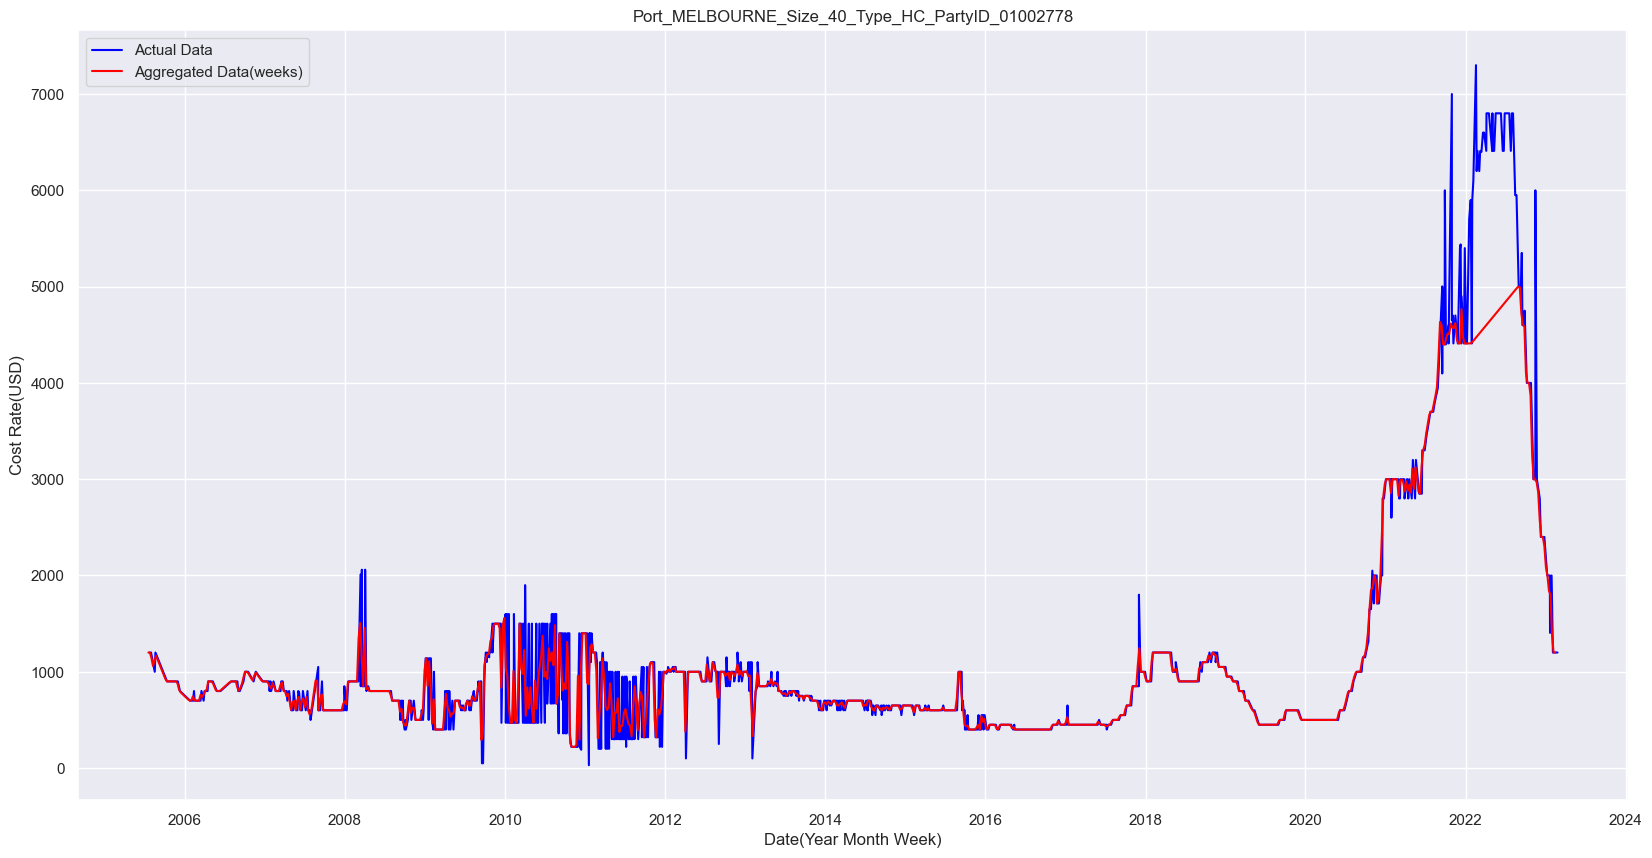

In [41]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>LSTM Regression<h4>

In [42]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Update create_dataset to handle multi-feature dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers):
    model = Sequential()
    
    for i in range(len(lstm_layers)):
        if i == 0:
            # First layer specifies the input_shape and returns sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, input_shape=(look_back, trainX.shape[2]), 
                           activation='tanh', recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        elif i == len(lstm_layers) - 1:
            # Last layer doesn't return sequences
            model.add(LSTM(lstm_layers[i], activation='tanh', kernel_regularizer=l2(0.01)))
        else:
            # Middle layers return sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, activation='tanh', 
                           recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))
        
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005))
    model.summary()

    # Add early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=128, verbose=2, 
                        validation_data=(testX, testY), callbacks=[es])
    return model, history


def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 50 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_24 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_25 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_25 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_26 (LSTM)              (None, 5, 32)             12416     
                                                                 
 dropout_26 (Dropout)        (None, 5, 32)             0         
                        

9/9 [==============================] - 0s 6ms/step
Train Score: 247.40 RMSE for 50 epochs
Test Score: 2121.52 RMSE for 50 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 5, 32)             4352      
                                                                 
 dropout_36 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_37 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_37 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_38 (LSTM)              (None, 5, 16)             3136      
                                                             

9/9 [==============================] - 0s 5ms/step
Train Score: 247.26 RMSE for 50 epochs
Test Score: 2120.74 RMSE for 50 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 5, 16)             1152      
                                                                 
 dropout_46 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_47 (LSTM)              (None, 5, 16)             2112      
                                                                 
 dropout_47 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_48 (LSTM)              (None, 5, 8)              800       
                                                                 
 dr

9/9 [==============================] - 0s 4ms/step
Train Score: 246.52 RMSE for 50 epochs
Test Score: 2115.90 RMSE for 50 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 5, 8)              320       
                                                                 
 dropout_54 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_55 (LSTM)              (None, 5, 8)              544       
                                                                 
 dropout_55 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_56 (LSTM)              (None, 5, 4)              208       
                                                                 
 dropout_56

9/9 [==============================] - 0s 3ms/step
Train Score: 247.24 RMSE for 50 epochs
Test Score: 2120.74 RMSE for 50 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 5, 4)              96        
                                                                 
 dropout_60 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_61 (LSTM)              (None, 5, 4)              144       
                                                                 
 dropout_61 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_62 (LSTM)              (None, 5, 2)              56        
                                                                 
 dropout_62 (Drop

9/9 [==============================] - 0s 2ms/step
Train Score: 246.64 RMSE for 50 epochs
Test Score: 2115.93 RMSE for 50 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 5, 2)              32        
                                                                 
 dropout_64 (Dropout)        (None, 5, 2)              0         
                                                                 
 lstm_65 (LSTM)              (None, 2)                 40        
                                                                 
 dropout_65 (Dropout)        (None, 2)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
Total params: 75
Traina

9/9 [==============================] - 0s 2ms/step
Train Score: 291.70 RMSE for 50 epochs
Test Score: 2598.31 RMSE for 50 epochs
Training for 100 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_66 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_67 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_67 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_68 (LSTM)              (None, 5, 32)             12416     
                          

9/9 [==============================] - 0s 6ms/step
Train Score: 246.04 RMSE for 100 epochs
Test Score: 2111.55 RMSE for 100 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 5, 32)             4352      
                                                                 
 dropout_78 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_79 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_79 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_80 (LSTM)              (None, 5, 16)             3136      
                                                           

9/9 [==============================] - 0s 5ms/step
Train Score: 246.11 RMSE for 100 epochs
Test Score: 2112.30 RMSE for 100 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 5, 16)             1152      
                                                                 
 dropout_88 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_89 (LSTM)              (None, 5, 16)             2112      
                                                                 
 dropout_89 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_90 (LSTM)              (None, 5, 8)              800       
                                                                 


9/9 [==============================] - 0s 4ms/step
Train Score: 246.19 RMSE for 100 epochs
Test Score: 2113.10 RMSE for 100 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 5, 8)              320       
                                                                 
 dropout_96 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_97 (LSTM)              (None, 5, 8)              544       
                                                                 
 dropout_97 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_98 (LSTM)              (None, 5, 4)              208       
                                                                 
 dropout

9/9 [==============================] - 0s 3ms/step
Train Score: 246.13 RMSE for 100 epochs
Test Score: 2112.48 RMSE for 100 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_102 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_102 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_103 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_103 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_104 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_104 (

9/9 [==============================] - 0s 2ms/step
Train Score: 246.17 RMSE for 100 epochs
Test Score: 2112.73 RMSE for 100 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_106 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_106 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_107 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_107 (Dropout)       (None, 2)                 0         
                                                                 
 dense_13 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Tra

9/9 [==============================] - 0s 2ms/step
Train Score: 247.93 RMSE for 100 epochs
Test Score: 2136.80 RMSE for 100 epochs
Training for 150 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_108 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_108 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_109 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_109 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_110 (LSTM)             (None, 5, 32)             12416     
                       

9/9 [==============================] - 0s 6ms/step
Train Score: 245.78 RMSE for 150 epochs
Test Score: 2107.91 RMSE for 150 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_120 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_121 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_121 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_122 (LSTM)             (None, 5, 16)             3136      
                                                          

9/9 [==============================] - 0s 4ms/step
Train Score: 245.74 RMSE for 150 epochs
Test Score: 2107.19 RMSE for 150 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_130 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_130 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_131 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_131 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_132 (LSTM)             (None, 5, 8)              800       
                                                                 


9/9 [==============================] - 0s 4ms/step
Train Score: 245.70 RMSE for 150 epochs
Test Score: 2106.16 RMSE for 150 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_138 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_138 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_139 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_139 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_140 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout

9/9 [==============================] - 0s 3ms/step
Train Score: 245.78 RMSE for 150 epochs
Test Score: 2107.94 RMSE for 150 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_144 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_144 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_145 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_145 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_146 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_146 (

9/9 [==============================] - 0s 2ms/step
Train Score: 245.83 RMSE for 150 epochs
Test Score: 2108.85 RMSE for 150 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_148 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_148 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_149 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_149 (Dropout)       (None, 2)                 0         
                                                                 
 dense_19 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Tra

9/9 [==============================] - 0s 2ms/step
Train Score: 231.46 RMSE for 150 epochs
Test Score: 1903.44 RMSE for 150 epochs
Training for 300 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_150 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_150 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_151 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_151 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_152 (LSTM)             (None, 5, 32)             12416     
                       

9/9 [==============================] - 0s 6ms/step
Train Score: 245.65 RMSE for 300 epochs
Test Score: 2104.56 RMSE for 300 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_162 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_162 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_163 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_163 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_164 (LSTM)             (None, 5, 16)             3136      
                                                          

9/9 [==============================] - 0s 5ms/step
Train Score: 245.63 RMSE for 300 epochs
Test Score: 2100.99 RMSE for 300 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_172 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_172 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_173 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_173 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_174 (LSTM)             (None, 5, 8)              800       
                                                                 


9/9 [==============================] - 0s 4ms/step
Train Score: 245.62 RMSE for 300 epochs
Test Score: 2102.56 RMSE for 300 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_180 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_180 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_181 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_181 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_182 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout

9/9 [==============================] - 0s 3ms/step
Train Score: 245.64 RMSE for 300 epochs
Test Score: 2104.12 RMSE for 300 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_186 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_186 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_187 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_187 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_188 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_188 (

9/9 [==============================] - 0s 2ms/step
Train Score: 245.62 RMSE for 300 epochs
Test Score: 2102.67 RMSE for 300 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_190 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_190 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_191 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_191 (Dropout)       (None, 2)                 0         
                                                                 
 dense_25 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Tra

9/9 [==============================] - 0s 2ms/step
Train Score: 245.60 RMSE for 300 epochs
Test Score: 2100.91 RMSE for 300 epochs


Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

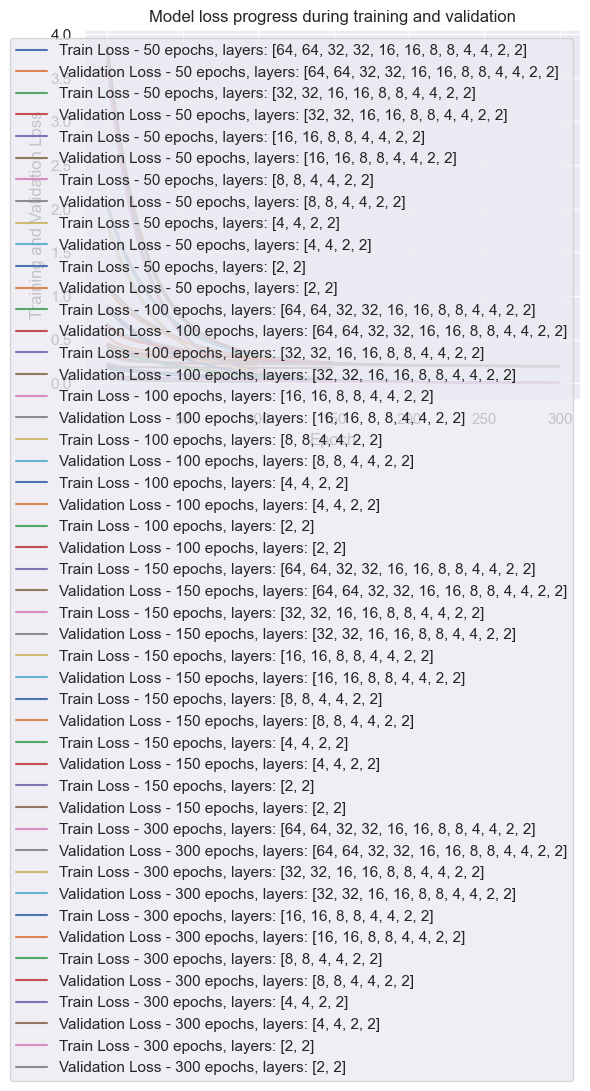

                                                    Train RMSE    Test RMSE
50 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4,...  247.397520  2121.515226
50 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] l...  247.258200  2120.736999
50 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers        246.518380  2115.904433
50 epochs, [8, 8, 4, 4, 2, 2] layers                247.237827  2120.736880
50 epochs, [4, 4, 2, 2] layers                      246.642392  2115.927963
50 epochs, [2, 2] layers                            291.700939  2598.314836
100 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4...  246.039132  2111.552732
100 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] ...  246.108931  2112.302339
100 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers       246.188554  2113.095347
100 epochs, [8, 8, 4, 4, 2, 2] layers               246.126472  2112.480656
100 epochs, [4, 4, 2, 2] layers                     246.168748  2112.732128
100 epochs, [2, 2] layers                           247.929575  2136.795257
150 epochs, 

In [45]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler

# Initialize two separate scalers
scaler_rate = MinMaxScaler(feature_range=(0, 1))

# Fit and transform 'RATE' and 'during_covid' separately
rate_scaled = scaler_rate.fit_transform(agg_df[['Rate']])

# Concatenate the scaled data
dataset = np.concatenate([rate_scaled], axis=1)

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

epochs_list = [50, 100, 150, 300]

lstm_layers_list = [
    [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [16, 16, 8, 8, 4, 4, 2, 2],
    [8, 8, 4, 4, 2, 2],
    [4, 4, 2, 2],
    [2, 2]
]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    
    for lstm_layers in lstm_layers_list:
        print(f'Training with LSTM layers: {lstm_layers}')
        model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers)
        
        # Add the loss for this model to the plot
        plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs, layers: {lstm_layers}')
        plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs, layers: {lstm_layers}')

        # Evalute LSTM Model
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # inverse_transform
        trainPredict = scaler_rate.inverse_transform(trainPredict)
        trainY_orig = scaler_rate.inverse_transform([trainY])
        testPredict = scaler_rate.inverse_transform(testPredict)
        testY_orig = scaler_rate.inverse_transform([testY])

        # Calculate mean squared error
        trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
        print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
        testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
        print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

        rmse_results[f'{epochs} epochs, {lstm_layers} layers'] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Configure and show the plot
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend()
plt.show();

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

<h4>Forecast the results</h4>

In [51]:
# Add check for 'RATE_actual' values to avoid division by zero
def compute_accuracy(row):
    if row['RATE_actual'] == 0:
        return np.nan
    else:
        error = abs(row['RATE_actual'] - row['RATE_forecasted'])
        error_proportion = error / row['RATE_actual']
        return (1 - error_proportion) * 100

def forecast_next_weeks(model, look_back, scaler, last_values, n_weeks):
    forecast = []
    for _ in range(n_weeks):
        last_values_2d = np.array(last_values[-look_back:]).reshape(-1, 1)
        input_values_scaled = scaler.transform(last_values_2d)
        input_values_scaled = input_values_scaled.reshape((1, look_back, 1))

        prediction = model.predict(input_values_scaled)
        prediction = scaler.inverse_transform(prediction)
        forecast.append(prediction[0][0])
        last_values.append(prediction[0][0])

    return forecast

In [52]:
weeks = 12

# Ensure that 'YearMonthWeek' is a datetime object
agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
last_date = agg_df['YearMonthWeek'].iloc[-1]

last_values = list(agg_df['Rate'].values[-look_back:])
forecasted_values = forecast_next_weeks(model, look_back, scaler_rate, last_values, weeks)
forecasted_dates = pd.date_range(start=last_date, periods=weeks+1, freq='W')[1:]

df_forecasted = pd.DataFrame({
    'POD': forecasted_dates,
    'RATE': forecasted_values
})

df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()

1/1 [==============================] - 0s 21ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 23ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,POD,RATE
0,2023-02-26,731.539978
1,2023-03-05,731.510010
2,2023-03-12,731.429993
3,2023-03-19,731.380005
4,2023-03-26,731.330017


,POD,RATE
7,2023-04-16,731.25
8,2023-04-23,731.25
9,2023-04-30,731.25
10,2023-05-07,731.25
11,2023-05-14,731.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 272.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [53]:
comparison_df = pd.DataFrame(columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')  

for _, row in df_forecasted.iterrows():
    mask = (new_dates_df['POD'] >= row['POD']) & (new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    for _, actual_row in actual_dates_within_week.iterrows():
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE']
        }, ignore_index=True)

# Remove duplicates
comparison_df = comparison_df.drop_duplicates(subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Compute accuracy
comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
comparison_df = comparison_df.dropna(subset=['accuracy'])

total_mean_accuracy = comparison_df['accuracy'].mean()
comparison_df
print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_36436\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_36436\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_36436\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_36436\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\U

,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,accuracy
0,2023-02-26,2023-03-05,2023-03-02,731.539978,1000.0,73.153998
1,2023-03-05,2023-03-12,2023-03-10,731.510010,1000.0,73.151001
2,2023-03-12,2023-03-19,2023-03-16,731.429993,1000.0,73.142999
3,2023-03-19,2023-03-26,2023-03-21,731.380005,600.0,78.103333
4,2023-03-26,2023-04-02,2023-03-26,731.330017,600.0,78.111664
5,2023-03-26,2023-04-02,2023-03-31,731.330017,650.0,87.487690
6,2023-04-02,2023-04-09,2023-04-06,731.250000,650.0,87.500000
7,2023-04-09,2023-04-16,2023-04-13,731.250000,650.0,87.500000
8,2023-04-16,2023-04-23,2023-04-20,731.250000,650.0,87.500000
9,2023-04-23,2023-04-30,2023-04-28,731.250000,500.0,53.750000


The mean accuracy is 69.55%



<h4>Visualise all, Conclusion</h4>

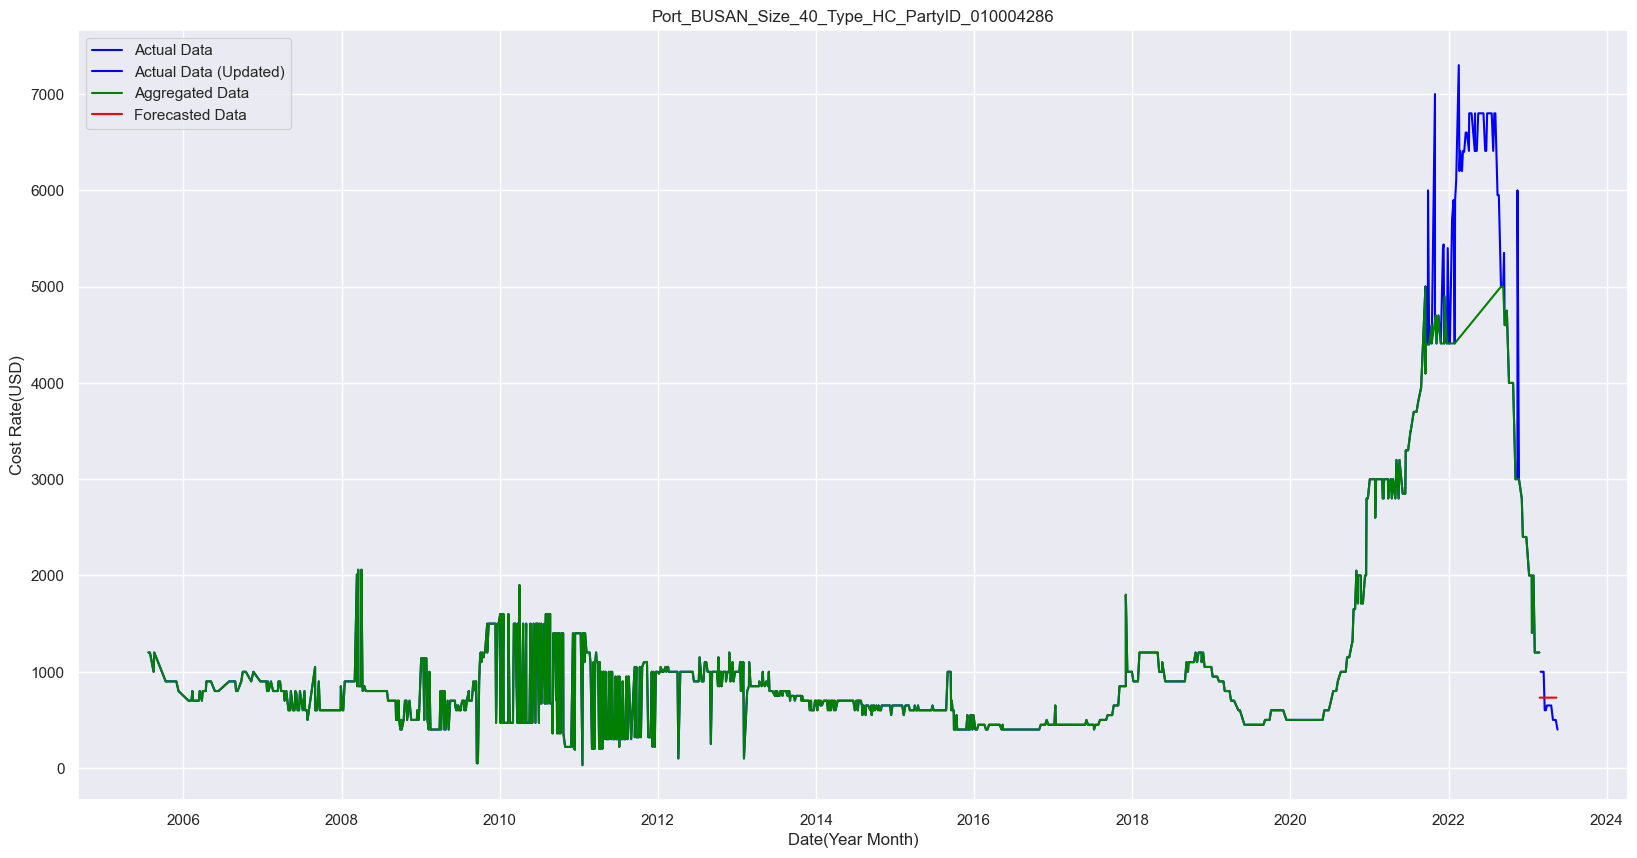

In [54]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();